In [135]:
import pandas as pd
import numpy as np
import random
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay

import warnings
warnings.filterwarnings("ignore")

ImportError: cannot import name 'CalibrationDisplay' from 'sklearn.calibration' (C:\Users\merie\anaconda3\lib\site-packages\sklearn\calibration.py)

In [52]:
# Read and preprocess data
df = pd.read_csv('../data/AllSeasonsM2Q2.csv')

df = df.drop('Unnamed: 0', 1)
df = df[['distance', 'angle', 'Goal']]
df = df.rename({'Goal': 'is_goal'}, axis=1)
df = df[~(df['is_goal'].isnull() | df['distance'].isnull() | df['angle'].isnull())] #remove after fix
df['is_goal'] = df['is_goal'].astype(np.int64)
df.head()

,distance,angle,is_goal
0,13.000000,67.380135,0
1,13.341664,167.005383,0
2,76.157731,60.068488,0
3,57.974132,75.004921,0
4,61.717096,63.019769,0


In [15]:
df.columns

Index(['index', 'eventType', 'period', 'periodTime', 'periodType', 'gameID',
       'teamOfShooter', 'homeOrAway', 'xCoord', 'yCoord', 'shooter', 'goalie',
       'shotType', 'emptyNet', 'strength', 'season', 'rinkSide', 'gameType',
       'totalPlayTime', 'lastEventType', 'lastEventPeriod',
       'lastEventPeriodTime', 'lastEventXCoord', 'lastEventYCoord', 'Goal',
       'EmptyNet', 'distanceFromNet', 'angle', 'gameSeconds',
       'lastEventGameSeconds', 'timeFromLastEvent', 'distanceFromLastEvent',
       'rebound', 'lastEventAngle', 'changeInAngleShot', 'speed'],
      dtype='object')

In [54]:
X = df.drop('is_goal', 1)
y = df['is_goal'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train[['distance', 'angle']]

,distance,angle
143124,52.497619,72.255328
9667,29.427878,9.782407
285044,37.121422,94.635463
50783,49.000000,90.000000
241011,10.049876,95.710593
...,...,...
122591,35.805028,125.909723
304154,58.051701,79.077195
152327,9.433981,57.994617
117964,57.271284,65.224859


### Question-1:

In [4]:
### XGBoost on distance+angle ###

X_train1 = X_train[['distance', 'angle']].to_numpy().reshape(-1, 2)
X_val1 = X_val[['distance', 'angle']].to_numpy().reshape(-1, 2)

xgb_clf1 = XGBClassifier().fit(X_train1, y_train)


train_score1 = xgb_clf1.score(X_train1, y_train)
val_score1 = xgb_clf1.score(X_val1, y_val)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')

[17:19:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 0.9050266312945303
Validation accuracy: 0.9063113145846958


In [5]:
### Random baseline ###
random_clf = DummyClassifier(strategy="uniform").fit(X_train1, y_train)

train_score0 = random_clf.score(X_train1, y_train)
val_score0 = random_clf.score(X_val1, y_val)

print(f'Training accuracy: {train_score0}')
print(f'Validation accuracy: {val_score0}')

Training accuracy: 0.4999611669534862
Validation accuracy: 0.4988227599738391


XGBoost (trained on distance+angle): ROC AUC=0.712
Random: ROC AUC=0.500


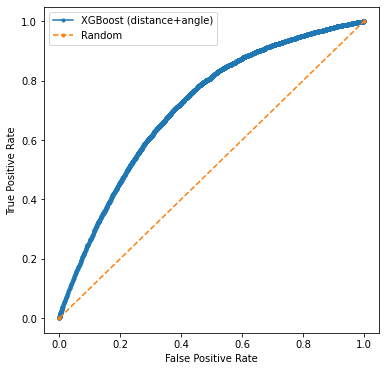

In [6]:
### ROC curve - AUC metric ###

xgb_probs1 = xgb_clf1.predict_proba(X_val1[:, :])[:,1]
random_probs = random_clf.predict_proba(X_val1[:, :])[:,1]


xgb_auc1 = roc_auc_score(y_val, xgb_probs1)
random_auc = roc_auc_score(y_val, random_probs)

print('XGBoost (trained on distance+angle): ROC AUC=%.3f' % (xgb_auc1))
print('Random: ROC AUC=%.3f' % (random_auc))

xgb_fpr1, xgb_tpr1, _ = roc_curve(y_val, xgb_probs1)
random_fpr, random_tpr, _ = roc_curve(y_val, random_probs)

plt.figure(figsize=(6, 6))

plt.plot(xgb_fpr1, xgb_tpr1, marker='.', label='XGBoost (distance+angle)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plt.savefig('../figures/roc.png')

plt.show()

In [125]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

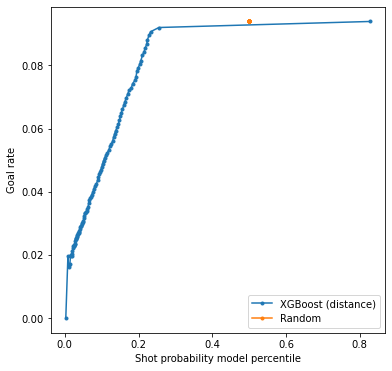

In [7]:
### goal_rate = F(shot probability model percentile) ###



percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_1.png')

plt.show()

In [126]:

def compute_cumulative_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []
    cum_rate = 0

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        cum_rate += goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(cum_rate)
    return percentiles, rates



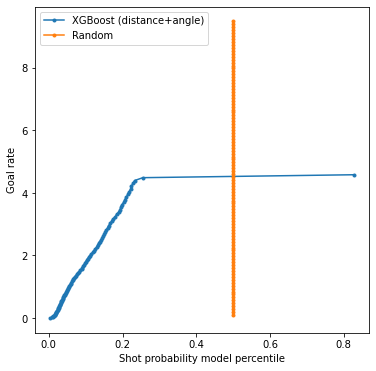

In [8]:
### cumulative portion of goals = F(shot probability model percentile) ###

percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs1, y_val)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (distance+angle)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()

# plt.savefig('../figures/goal_rate_percentile_2.png')

plt.show()

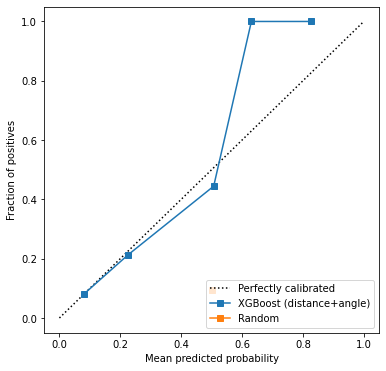

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

disp1 = CalibrationDisplay.from_estimator(xgb_clf1, X_val1, y_val, label='XGBoost (distance+angle)', ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_val1, y_val, label='Random', ax=ax)

# plt.savefig('../figures/calibration_diagram.png')

plt.show()

In [70]:
df.columns

Index(['Unnamed: 0', 'index', 'eventType', 'period', 'periodTime',
       'periodType', 'gameID', 'teamOfShooter', 'homeOrAway', 'xCoord',
       'yCoord', 'shooter', 'goalie', 'shotType', 'emptyNet', 'strength',
       'season', 'rinkSide', 'gameType', 'totalPlayTime', 'lastEventType',
       'lastEventPeriod', 'lastEventPeriodTime', 'lastEventXCoord',
       'lastEventYCoord', 'Goal', 'EmptyNet', 'distanceFromNet', 'angle',
       'gameSeconds', 'lastEventGameSeconds', 'timeFromLastEvent',
       'distanceFromLastEvent', 'rebound', 'lastEventAngle',
       'changeInAngleShot', 'speed'],
      dtype='object')

In [73]:
df[['gameSeconds','totalPlayTime']]  #difference ? 
#a problem with last event angle ? 

,gameSeconds,totalPlayTime
0,71,01:00:37
1,173,01:00:37
2,241,01:00:37
3,286,01:00:37
4,406,01:00:37
...,...,...
305809,3405,01:00:00
305810,3440,01:00:00
305811,3442,01:00:00
305812,3530,01:00:00


### Question-2: XGBoost classifier using all of the features:
Game seconds-
Game period-
Coordinates (x,y, separate columns)-
Shot distance-
Shot angle-
Shot type-
Empty net-
Last event type-
Coordinates of the last event (x, y, separate columns)-
Time from the last event (seconds)-
Distance from the last event-
Rebound (bool): -
Change in shot angle-
“Speed”-

In [119]:
df=  pd.read_csv('../data/AllSeasonsM2Q4.csv')

df['rebound']=df['rebound'].astype(int)
FinalDf = df[['gameSeconds','periodTime','xCoord','yCoord','distanceFromNet','angle','shotType','EmptyNet','lastEventType', 'lastEventXCoord',
       'lastEventYCoord','lastEventGameSeconds','distanceFromLastEvent','rebound', 'lastEventAngle',
       'changeInAngleShot', 'speed','Goal']]
obj_df=FinalDf.select_dtypes(include=['object']).copy()

FinalDf=FinalDf.drop(obj_df.columns, axis=1)

obj_df=obj_df.apply(preprocessing.LabelEncoder().fit_transform)
Frame=pd.concat([FinalDf,obj_df],axis=1)





In [120]:
X = Frame.drop('Goal', 1)
y = Frame['Goal'].to_numpy()
X_trainXG_All, X_valXG_All, y_trainXG_All, y_valXG_All = train_test_split(X, y, test_size=0.2, random_state=0)


In [122]:
### XGBoost using all features only encoding  ###

X_train1XG_All = X_trainXG_All.to_numpy().reshape(-1, len(X_trainXG_All.columns))
X_val1XG_All = X_valXG_All.to_numpy().reshape(-1, len(X_trainXG_All.columns))

xgb_clf2 = XGBClassifier().fit(X_train1XG_All, y_trainXG_All)

train_score1 = xgb_clf2.score(X_train1XG_All, y_trainXG_All)
val_score1 = xgb_clf2.score(X_val1XG_All, y_valXG_All)

print(f'Training accuracy: {train_score1}')
print(f'Validation accuracy: {val_score1}')

C:\Users\merie\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy: 0.9127818811286281
Validation accuracy: 0.9090626686068375


Training accuracy: 0.4992499519724015
Validation accuracy: 0.4987492438238805
XGBoost (trained on all ffeatures): ROC AUC=0.767
Random: ROC AUC=0.500


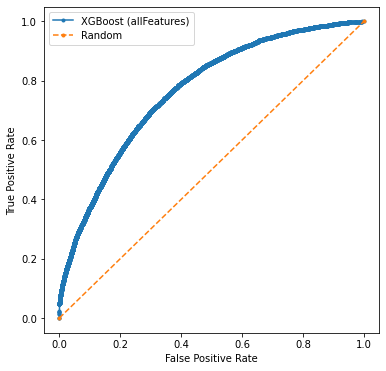

In [123]:
### ROC curve - AUC metric ###
random_clf2 = DummyClassifier(strategy="uniform").fit(X_trainXG_All, y_trainXG_All)

train_score2 = random_clf2.score(X_trainXG_All, y_trainXG_All)
val_score2 = random_clf2.score(X_val1XG_All, y_valXG_All)

print(f'Training accuracy: {train_score2}')
print(f'Validation accuracy: {val_score2}')

xgb_probs2 = xgb_clf2.predict_proba(X_val1XG_All[:, :])[:,1]
random_probs2 = random_clf2.predict_proba(X_val1XG_All[:, :])[:,1]


xgb_auc2 = roc_auc_score(y_val, xgb_probs2)
random_auc2 = roc_auc_score(y_val, random_probs2)

print('XGBoost (trained on all ffeatures): ROC AUC=%.3f' % (xgb_auc2))
print('Random: ROC AUC=%.3f' % (random_auc2))

xgb_fpr1, xgb_tpr1, _ = roc_curve(y_valXG_All, xgb_probs2)
random_fpr, random_tpr, _ = roc_curve(y_valXG_All, random_probs2)

plt.figure(figsize=(6, 6))

plt.plot(xgb_fpr1, xgb_tpr1, marker='.', label='XGBoost (allFeatures)')
plt.plot(random_fpr, random_tpr, linestyle='--', marker='.', label='Random')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# plt.savefig('../figures/roc.png')

plt.show()

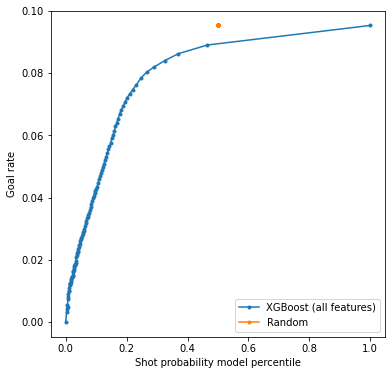

In [128]:
### goal_rate = F(shot probability model percentile) ###



percentiles1, rates1 = compute_goal_rate_per_percentile(xgb_probs2, y_valXG_All)
percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs2, y_valXG_All)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (all features)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()



plt.show()

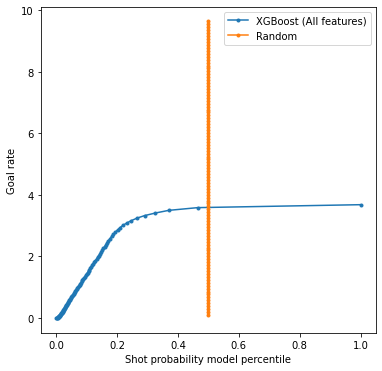

In [130]:
percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(xgb_probs2, y_valXG_All)
percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs2, y_valXG_All)

plt.figure(figsize=(6, 6))

plt.plot(percentiles1, rates1, marker='.', label='XGBoost (All features)')
plt.plot(percentiles2, rates2, marker='.', label='Random')

plt.xlabel('Shot probability model percentile')
plt.ylabel('Goal rate')
plt.legend()



plt.show()

NameError: name 'CalibrationDisplay' is not defined

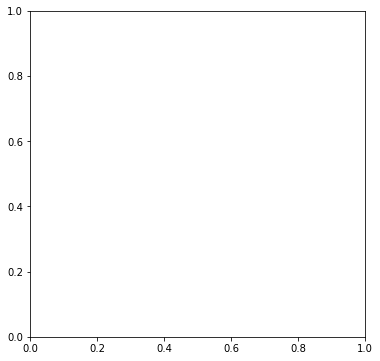

In [133]:
fig, ax = plt.subplots(figsize=(6, 6))

disp1 = CalibrationDisplay.from_estimator(xgb_clf1, X_valXG_All, y_valXG_All, label='XGBoost (All)', ax=ax)
disp4 = CalibrationDisplay.from_estimator(random_clf, X_valXG_All, y_valXG_All, label='Random', ax=ax)

# plt.savefig('../figures/calibration_diagram.png')

plt.show()

In [ ]:
### XGBoost using all features encoding + MinMaxScaling for some features ###
